In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
import monai.transforms as T
from monai.utils.misc import first

import matplotlib.pyplot as plt
import torchvision

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


In [3]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(60, 10))
    for i, img in enumerate(imgs):
        ndarr = img.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
        img = Image.fromarray(ndarr)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Load pretrained DAE

In [4]:
device = 'cuda:0'
conf = spider64_autoenc()
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 86.63 M


Data pipepline

In [5]:
batch_size = 1

train_spider_files = create_spider_files()
train_transforms = T.Compose([
        # each image has a single ivd label
        T.LoadImaged(keys=['image', 'mask'], ensure_channel_first=True),
        T.Orientationd(keys=['image', 'mask'], axcodes='RAS'),
        # median dataset spacing
        T.Spacingd(keys=['image', 'mask'],pixdim=(3.32, 0.625, 0.625), mode=("bilinear", "nearest")),
        T.ScaleIntensityRangePercentilesd(keys='image', lower=0, upper=99.5, b_min=0, b_max=1),
        # remove other labels from mask
        CropMaskByLabel(mask_key='mask', label_key='ivd_label', label_lambda_func=lambda x: x + 200),
        # some augmentations
        #T.RandGaussianNoised(keys=['image'], mean=0.0, std=0.015, prob=prob),
        #T.RandRotated(keys=['image', 'mask'], range_x=30 * (np.pi / 180), mode=["bilinear", "nearest"], prob=prob),
        # center and crop image around ivd
        T.CropForegroundd(keys=['image', 'mask'], source_key='mask', margin=(0, 80, 80), allow_smaller=False),
        T.CenterSpatialCropd(keys=['image', 'mask'], roi_size=(-1, 80, 80)),
        # get a single slice
        T.CenterSpatialCropd(keys=['image', 'mask'], roi_size=(1, -1, -1)),
        #T.RandSpatialCropd(keys=['image', 'mask'], roi_size=(1, -1, -1)),
        AssertEmptyImaged(),
        # resize
        T.Resized(keys=['image', 'mask'], spatial_size=(1, 64, 64), anti_aliasing=True),
        T.ToTensord(keys=['image', 'mask']),
        T.SqueezeDimd(keys=['image', 'mask'], dim=1), 
])

dataset_train = data.Dataset(train_spider_files, transform=train_transforms)
train_loader = DataLoader(dataset_train, batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [6]:
val_spider_files = create_spider_files(split="validation")

val_transforms = T.Compose([
        # each image has a single ivd label
        T.LoadImaged(keys=['image', 'mask'], ensure_channel_first=True),
        T.Orientationd(keys=['image', 'mask'], axcodes='RAS'),
        # median dataset spacing
        T.Spacingd(keys=['image', 'mask'],pixdim=(3.32, 0.625, 0.625), mode=("bilinear", "nearest")),
        T.ScaleIntensityRangePercentilesd(keys='image', lower=0, upper=99.5, b_min=0, b_max=1),
        # remove other labels from mask
        CropMaskByLabel(mask_key='mask', label_key='ivd_label', label_lambda_func=lambda x: x + 200),
        # center and crop image around ivd
        T.CropForegroundd(keys=['image', 'mask'], source_key='mask', margin=(0, 80, 80), allow_smaller=False),
        T.CenterSpatialCropd(keys=['image', 'mask'], roi_size=(-1, 80, 80)),
        # get a single slice
        T.CenterSpatialCropd(keys=['image', 'mask'], roi_size=(1, -1, -1)),
        AssertEmptyImaged(),
        # resize
        T.Resized(keys=['image', 'mask'], spatial_size=(1, 64, 64), anti_aliasing=True),
        T.ToTensord(keys=['image', 'mask']),
        T.SqueezeDimd(keys=['image', 'mask'], dim=1), 
])

dataset_val = data.Dataset(val_spider_files, transform=val_transforms)
val_loader = DataLoader(dataset_val, batch_size, shuffle=False, num_workers=8, pin_memory=True)

Missing grade, skipping IVD


In [7]:
len(train_spider_files) + len(val_spider_files)

1446

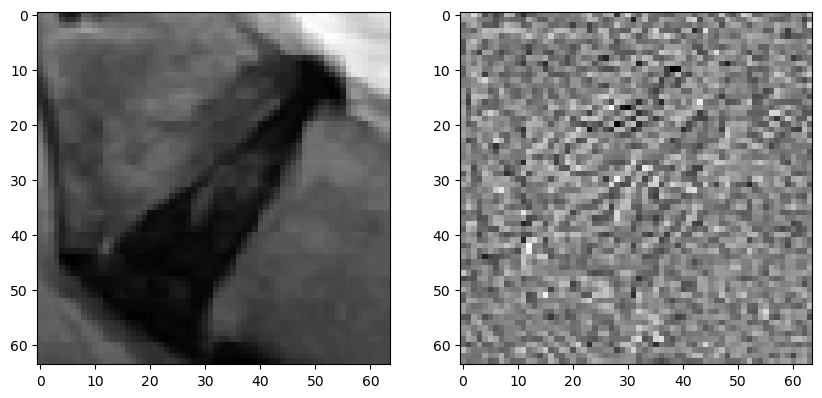

In [7]:
orig = first(val_loader)["image"].to(device)
cond = model.encode(orig, ema=True)
xT = model.encode_stochastic(orig, cond, T=250, ema=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(orig[0].permute(1, 2, 0).cpu(), cmap="gray")
ax[1].imshow(xT[0].permute(1, 2, 0).cpu(), cmap="gray")

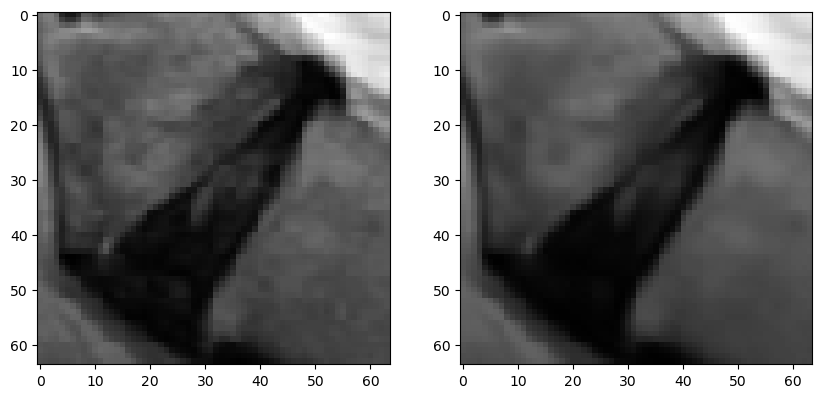

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
recon = model.render(xT, cond, T=100, ema=True)

ax[0].imshow(orig[0].permute(1, 2, 0).cpu(), cmap="gray")
ax[1].imshow(recon[0].permute(1, 2, 0).cpu(), cmap="gray")

Save preprocessed latents

In [11]:
with torch.no_grad():
    train_latents = list()
    train_labels = list()
    train_levels = list()
    for batch in tqdm(train_loader):
        img = batch['image']
        cond = model.encode(img.to(device), ema=True)
        cond = cond.cpu()

        train_latents.append(cond)
        train_labels.append(batch['pfirrman_grade'].item())
        train_levels.append(batch['ivd_label'].item())

    train_latents_np = torch.cat(train_latents, dim=0).cpu().detach().numpy()
    train_labels_np = np.array(train_labels).ravel()
    train_levels_np = np.array(train_levels).ravel()


    val_latents = list()
    val_labels = list()
    val_levels = list()
    for batch in tqdm(val_loader):
        img = batch['image']
        cond = model.encode(img.to(device), ema=True)
        cond = cond.cpu()

        val_latents.append(cond)
        val_labels.append(batch['pfirrman_grade'].item())
        val_levels.append(batch['ivd_label'].item())

    val_latents_np = torch.cat(val_latents, dim=0).cpu().detach().numpy()
    val_labels_np = np.array(val_labels).ravel()
    val_levels_np = np.array(val_levels).ravel()

  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

In [13]:
latents = {
    "train": {"latents": train_latents_np, "labels": train_labels_np, "levels": train_levels_np},
    "val": {"latents": val_latents_np, "labels": val_labels_np, "levels": val_levels_np}
} 

torch.save(latents, "spider_latents.pt")

In [3]:
latents = torch.load("latents/spider_latents.pt")
train_latents_np = latents["train"]["latents"]
train_labels_np = latents["train"]["labels"]
train_levels_np = latents["train"]["levels"]
val_latents_np = latents["val"]["latents"]
val_labels_np = latents["val"]["labels"]
val_levels_np = latents["val"]["levels"]

In [12]:
np.unique(train_labels_np, return_counts=True)

(array([0, 1, 2, 3, 4]), array([182, 304, 343, 214, 142]))

In [14]:
np.unique(val_labels_np, return_counts=True)

(array([0, 1, 2, 3, 4]), array([35, 35, 74, 77, 40]))

TSNE plot

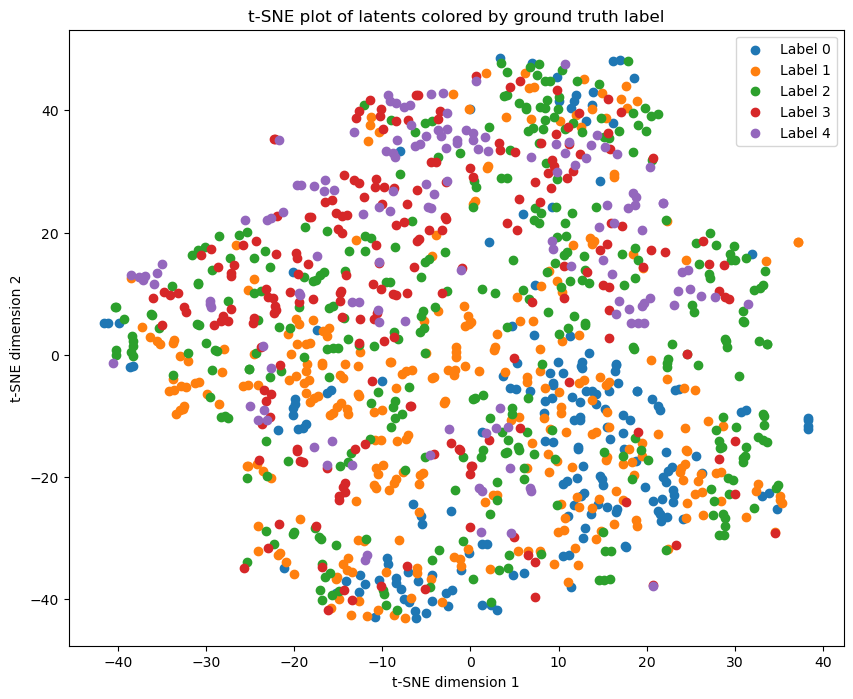

In [14]:
from sklearn.manifold import TSNE

# Run t-SNE on the dataset
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(train_latents_np)

# Plotting the result, coloring by label
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels_np):
    plt.scatter(latents_2d[train_labels_np == label, 0], latents_2d[train_labels_np == label, 1], label=f'Label {label}')

plt.legend()
plt.title('t-SNE plot of latents colored by ground truth label')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

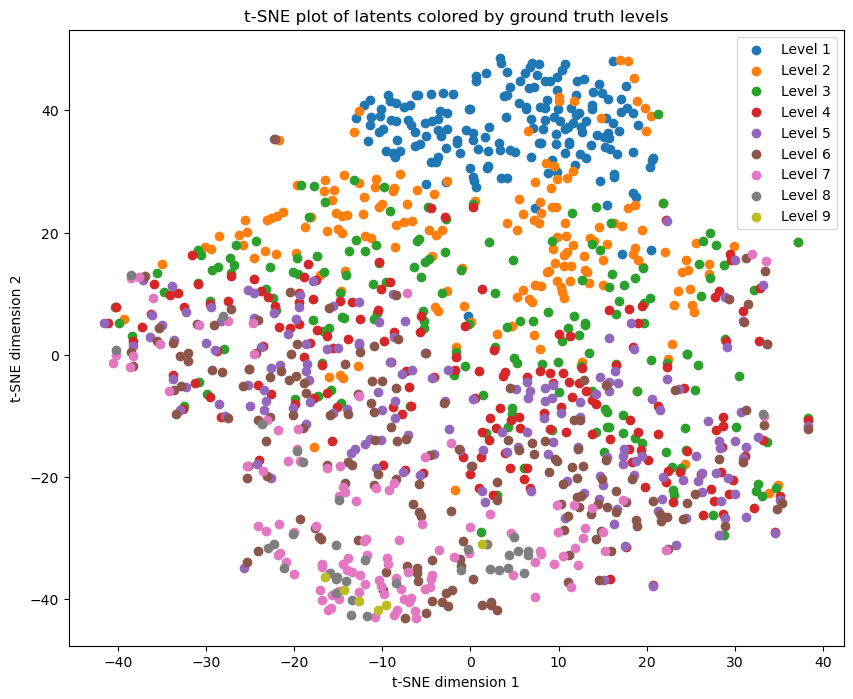

In [12]:
# Plotting the result, coloring by levels
plt.figure(figsize=(10, 8))
for level in np.unique(train_levels_np):
    plt.scatter(latents_2d[train_levels_np == level, 0], latents_2d[train_levels_np == level, 1], label=f'Level {level}')

plt.legend()
plt.title('t-SNE plot of latents colored by ground truth levels')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

Binary classifier

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# Convert labels to binary: 0 stays 0, anything above 0 becomes 1
y_train = (train_labels_np > 0).astype(int)
y_test = (val_labels_np > 0).astype(int)

# Train a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)  # Increased max_iter for convergence
lr_model.fit(train_latents_np, y_train)

# Train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear', random_state=42)  # Using a linear kernel
svm_model.fit(train_latents_np, y_train)

# Predict on the test set
svm_predictions = svm_model.predict(val_latents_np)
lr_predictions = lr_model.predict(val_latents_np)

# Evaluate the models
svm_accuracy = accuracy_score(y_test, svm_predictions)
lr_accuracy = accuracy_score(y_test, lr_predictions)


print("SVM Accuracy:", svm_accuracy)
print("LR Accuracy:", lr_accuracy)

f1 = f1_score(y_test, svm_predictions)
auc = roc_auc_score(y_test, svm_predictions)

print("SVM F1:", f1)
print("SVM AUC:", auc)


f1 = f1_score(y_test, lr_predictions)
auc = roc_auc_score(y_test, lr_predictions)

print("LR F1:", f1)
print("LR AUC:", auc)

SVM Accuracy: 0.8888888888888888
LR Accuracy: 0.8888888888888888
SVM F1: 0.9379014989293362
SVM AUC: 0.6702275600505689
LR F1: 0.9381663113006397
LR AUC: 0.6581542351453855


Regression on distance from decision boundary

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


latnets_mean = np.mean(train_latents_np, axis=0)
latnets_std = np.std(train_latents_np, axis=0)

# Assuming train_latents_np and val_latents_np are your training and validation feature matrices
w = svm_model.coef_
b = svm_model.intercept_

# Normalize w for the distance computation
w = w / np.linalg.norm(w)

# Compute the distance from the hyperplane for training and validation sets
train_distances = np.dot(train_latents_np, w.T) + b 
val_distances = np.dot(val_latents_np, w.T) + b

# Fit the linear model
lin_model = LinearRegression()
lin_model.fit(train_distances, train_labels_np)

# Predict on the validation set
lin_predictions = lin_model.predict(val_distances)

mae = mean_absolute_error(val_labels_np, lin_predictions)
print("SVM MAE:", mae)


f1 = f1_score(val_labels_np, lin_predictions.round(), average="macro")
print("SVM F1: ", f1)

# Fit the linear model
lin_model = LinearRegression()
lin_model.fit(train_distances, train_labels_np)

# Predict on the validation set
lin_predictions = lin_model.predict(val_distances)

mae = mean_absolute_error(val_labels_np, lin_predictions)
print("MAE:", mae)


f1 = f1_score(val_labels_np, lin_predictions.round(), average="macro")
print("F1: ", f1)

MAE: 0.8980105424280713
F1:  0.2517044268533535


Editing images

In [20]:
def move_across_boundary(sample, svm_model, gt_grade):
    dists = list()

    w = svm_model.coef_ 
    w = w / (np.linalg.norm(w) * np.sqrt(512))
    b = svm_model.intercept_

    # Decision function value for the original sample
    decision_value = np.dot(w, sample.T) + b
    reg_value = np.round(lin_model.predict(decision_value)[0])
    dists.append((decision_value[0][0], reg_value))
    
    print("Before (Dist, Reg): ", decision_value[0][0], reg_value)

    # normalize sample before editing
    sample = (sample - latnets_mean) / latnets_std
    
    # Determine the direction to move the sample based on its ground truth
    direction = 1 if gt_grade in [0, 1] else -1
    
    # Modify the sample
    edited = list()
    for step_size in np.arange(100, 801, 200):
        modified_sample = sample + direction * step_size * w
        modified_sample = modified_sample * latnets_std + latnets_mean

        decision_value =  np.dot(w, modified_sample.T) + b
        reg_value = np.round(lin_model.predict(decision_value)[0])
       
        modified_sample = torch.tensor(modified_sample, requires_grad=False, device=device).float()

        dists.append((decision_value[0][0], reg_value))
        edited.append(modified_sample)

    edited.reverse()
    print(dists)
    
    return edited

GT Grade:  1
Before (Dist, Reg):  2.287337000724114 2.0
[(2.287337000724114, 2.0), (2.3566555129453497, 2.0), (2.4952925376658475, 3.0), (2.633929562386345, 3.0), (2.7725665871068426, 4.0), (2.91120361182734, 4.0)]


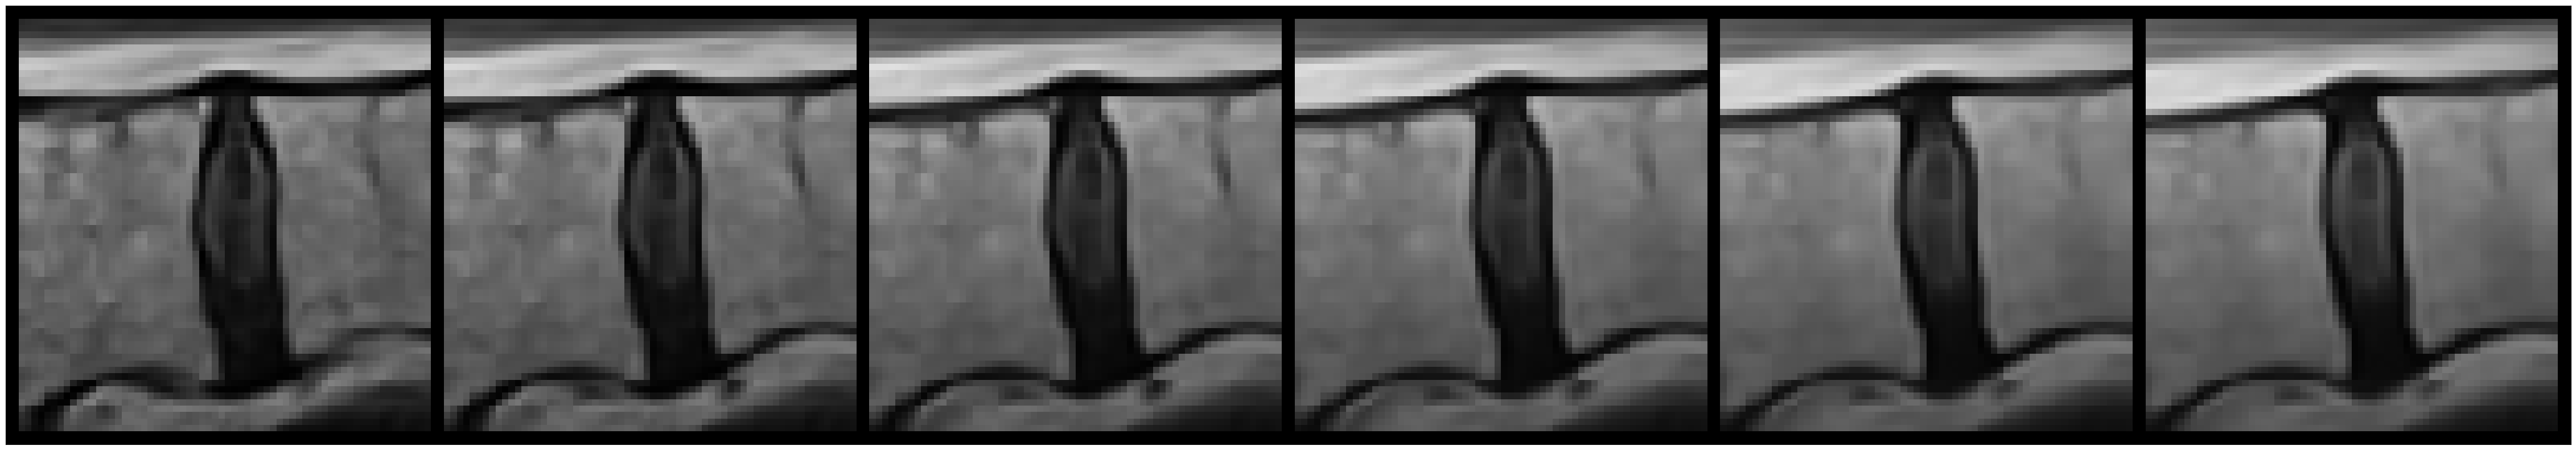

GT Grade:  0
Before (Dist, Reg):  2.2634046064696407 2.0
[(2.2634046064696407, 2.0), (2.332723118289669, 2.0), (2.471360143010166, 3.0), (2.609997167730664, 3.0), (2.7486341924511617, 4.0), (2.887271217171659, 4.0)]


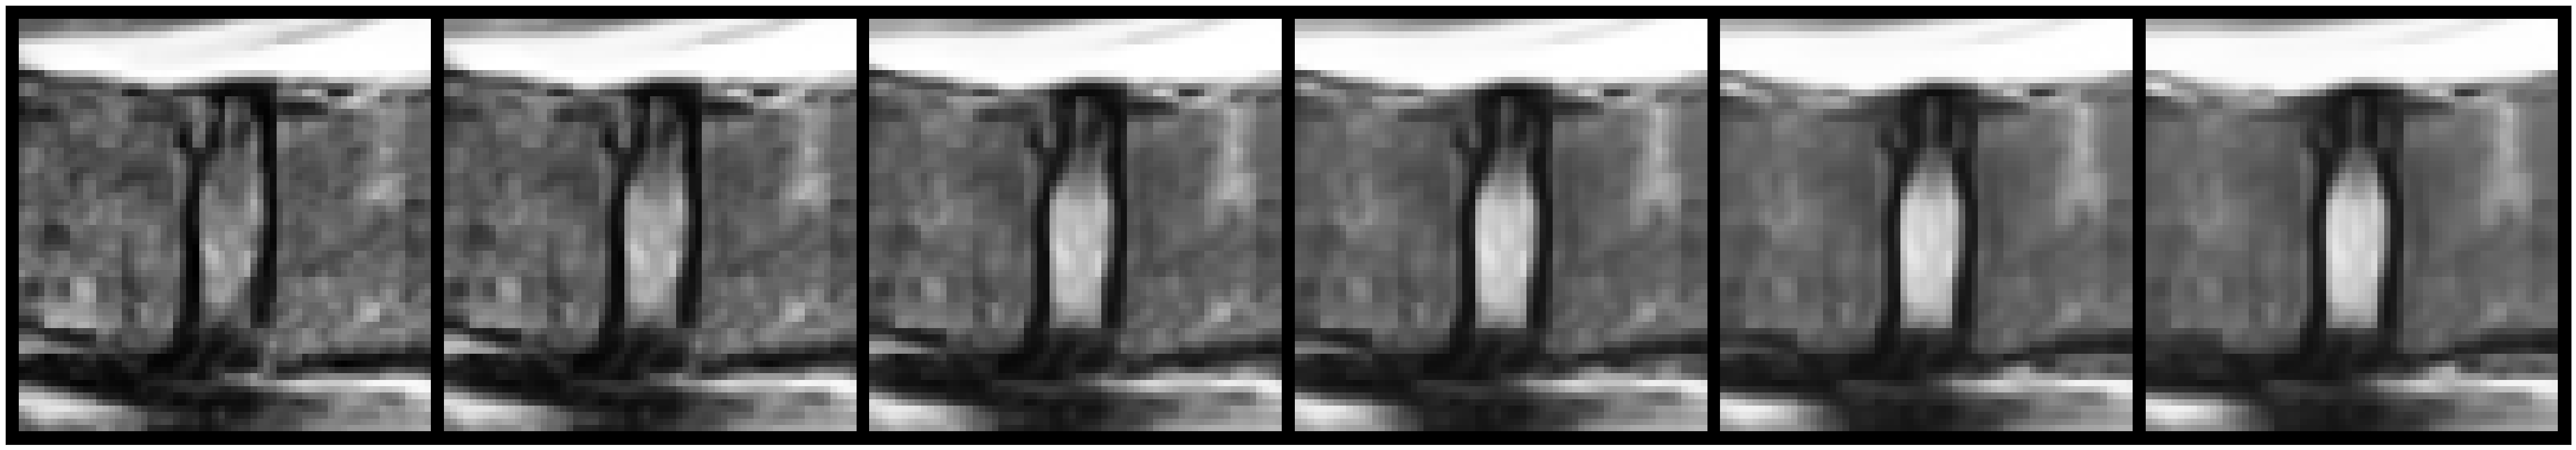

GT Grade:  0
Before (Dist, Reg):  2.2609684874125655 2.0
[(2.2609684874125655, 2.0), (2.3302869990949118, 2.0), (2.4689240238154095, 3.0), (2.6075610485359073, 3.0), (2.7461980732564046, 4.0), (2.8848350979769024, 4.0)]


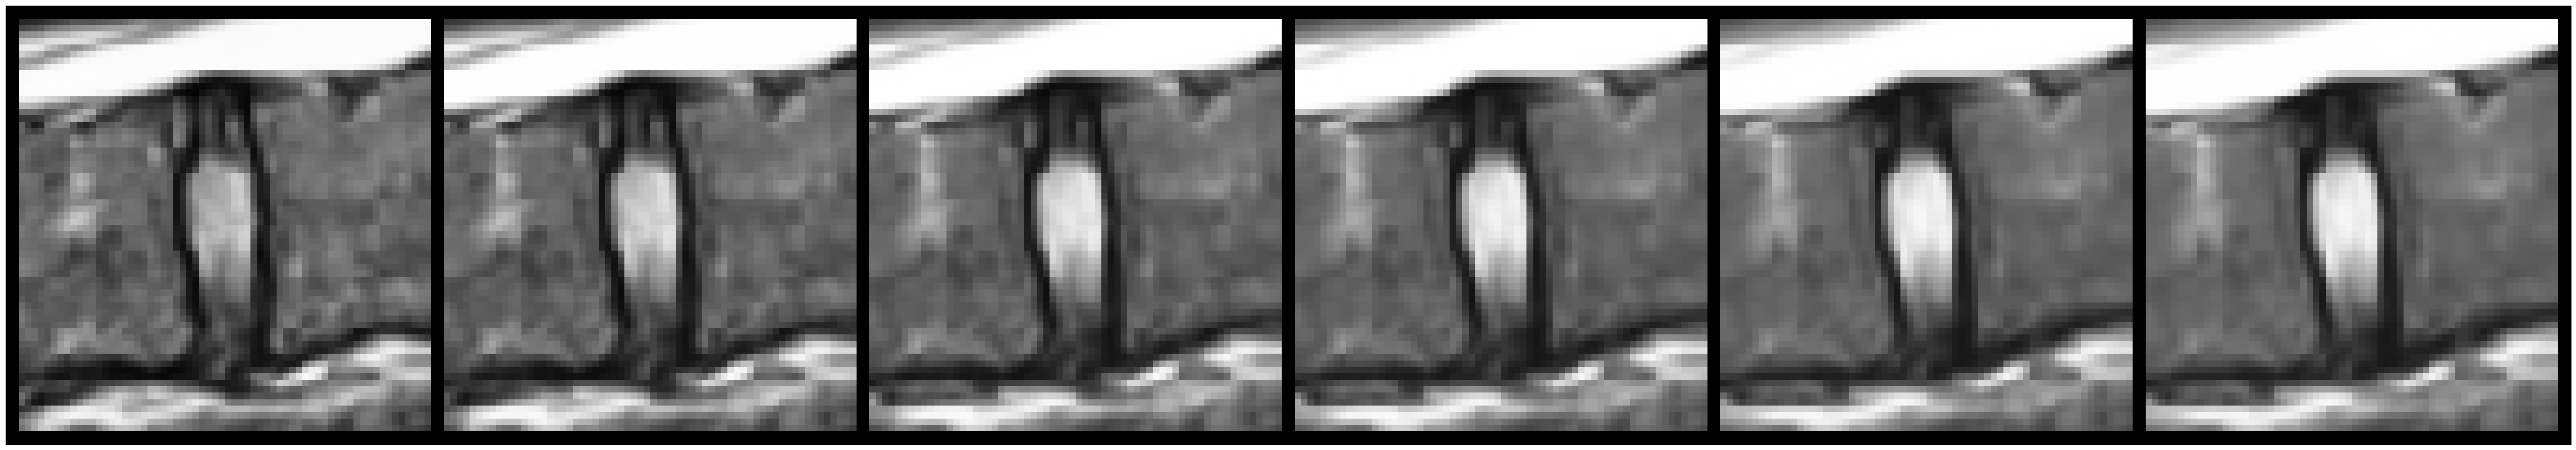

GT Grade:  0
Before (Dist, Reg):  2.2603826981939448 2.0
[(2.2603826981939448, 2.0), (2.329701210420939, 2.0), (2.4683382351414367, 3.0), (2.606975259861934, 3.0), (2.745612284582432, 4.0), (2.8842493093029296, 4.0)]


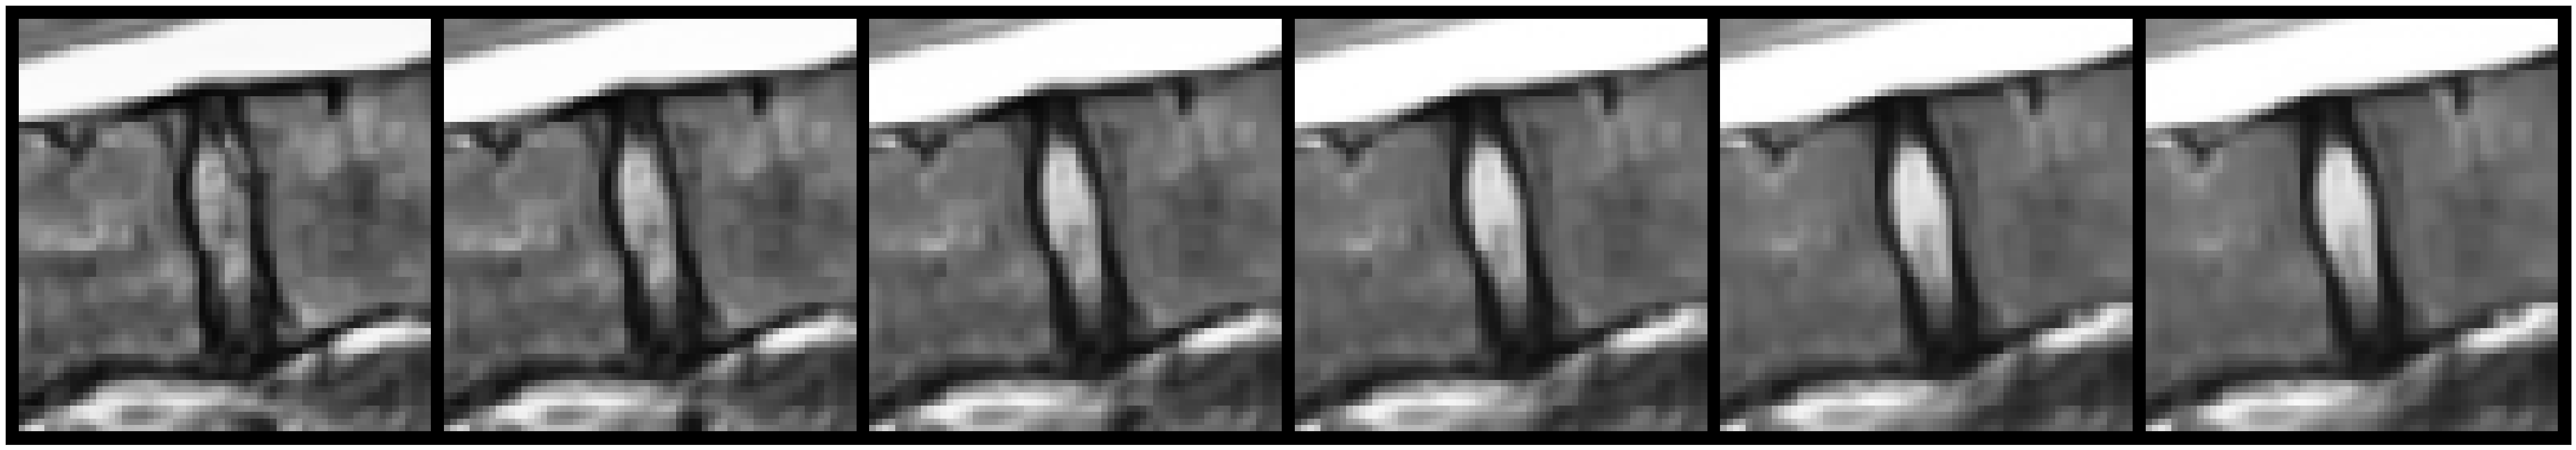

GT Grade:  0
Before (Dist, Reg):  2.2554621432212456 2.0
[(2.2554621432212456, 2.0), (2.324780654967593, 2.0), (2.4634176796880904, 3.0), (2.602054704408588, 3.0), (2.7406917291290855, 4.0), (2.8793287538495833, 4.0)]


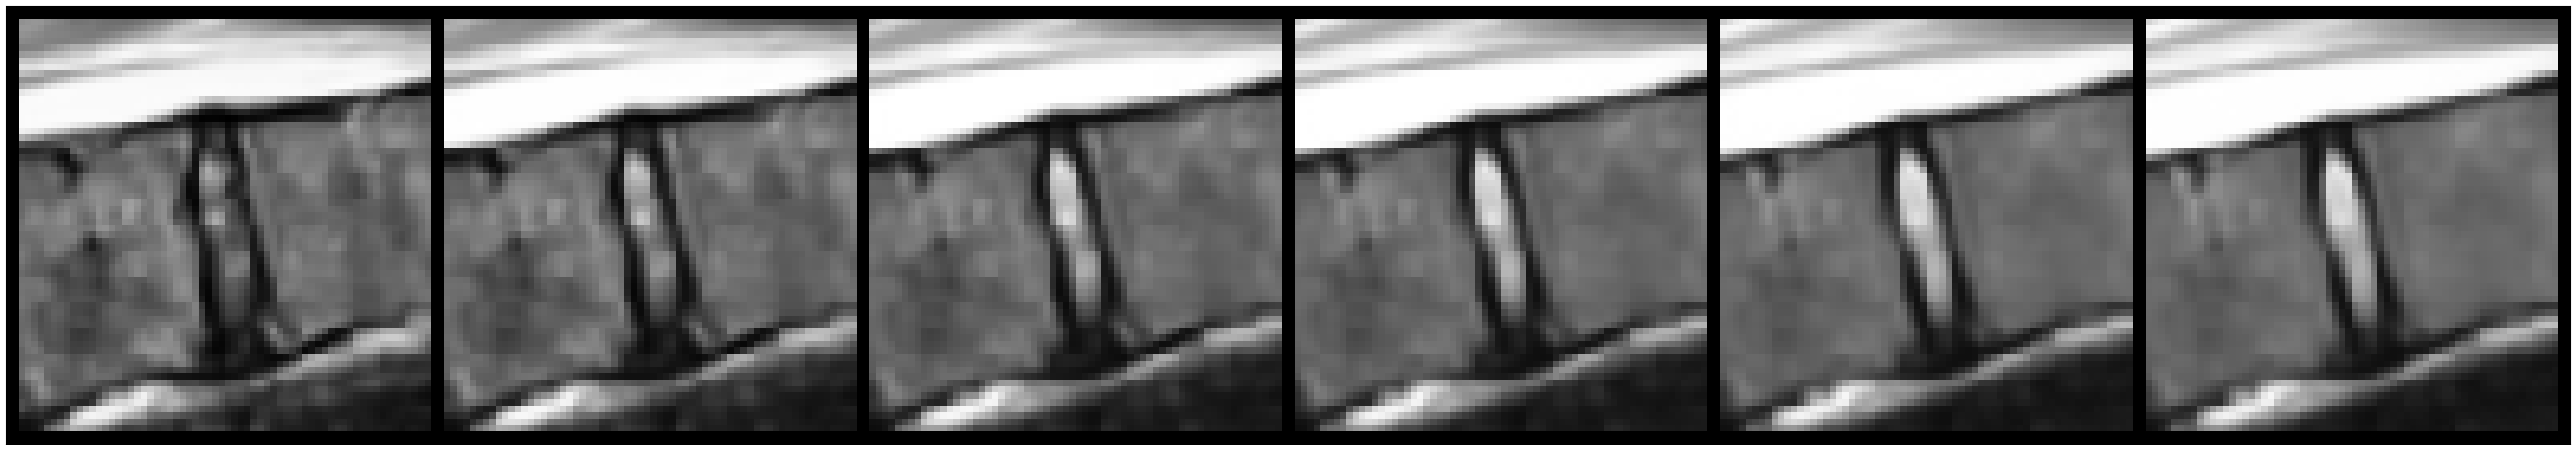

GT Grade:  0
Before (Dist, Reg):  2.2523125261963424 2.0
[(2.2523125261963424, 2.0), (2.321631038575136, 2.0), (2.4602680632956333, 3.0), (2.598905088016131, 3.0), (2.7375421127366284, 4.0), (2.876179137457126, 4.0)]


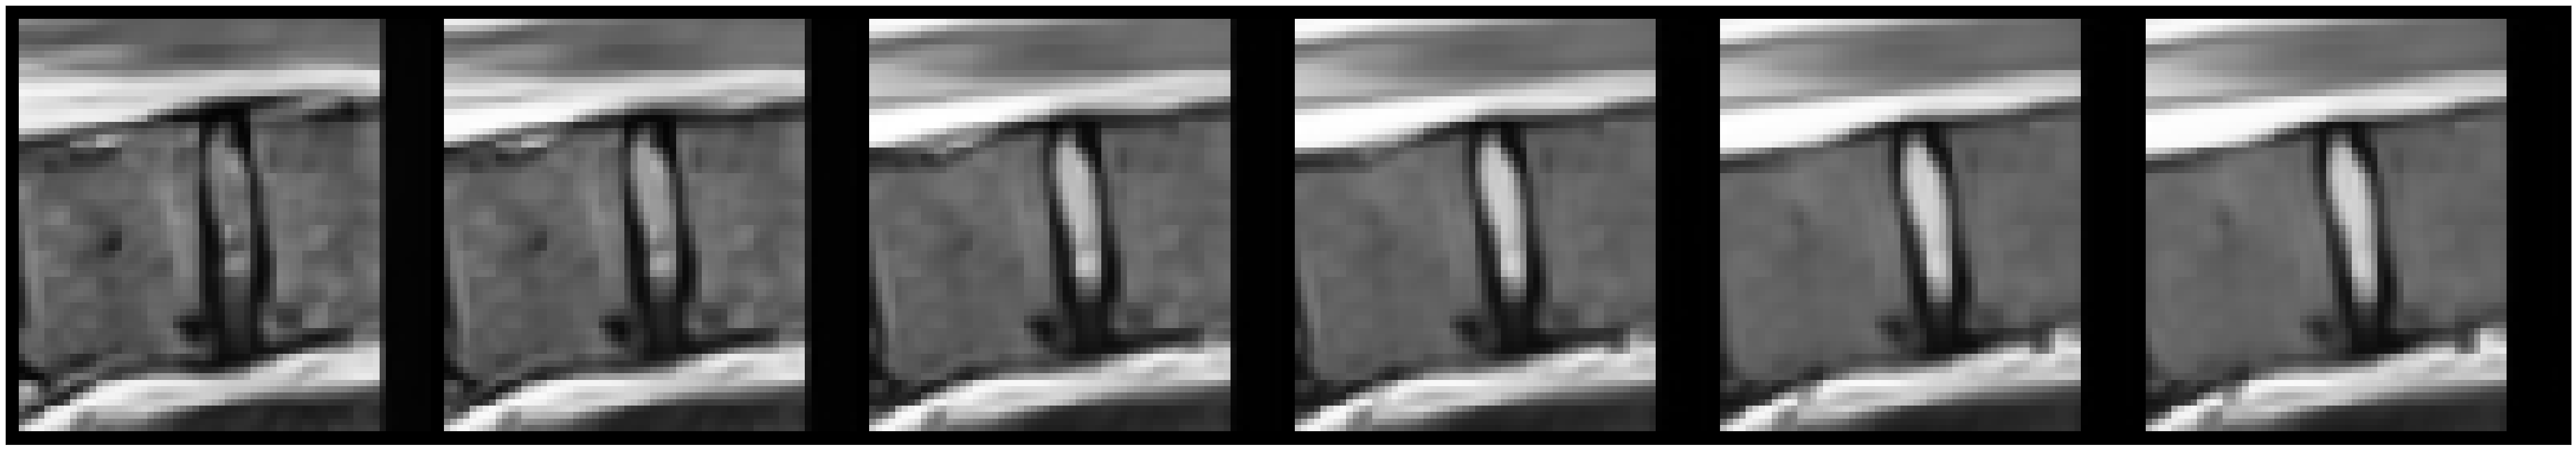

GT Grade:  1
Before (Dist, Reg):  2.2617329844274634 2.0
[(2.2617329844274634, 2.0), (2.331051496036825, 2.0), (2.4696885207573223, 3.0), (2.60832554547782, 3.0), (2.746962570198318, 4.0), (2.885599594918815, 4.0)]


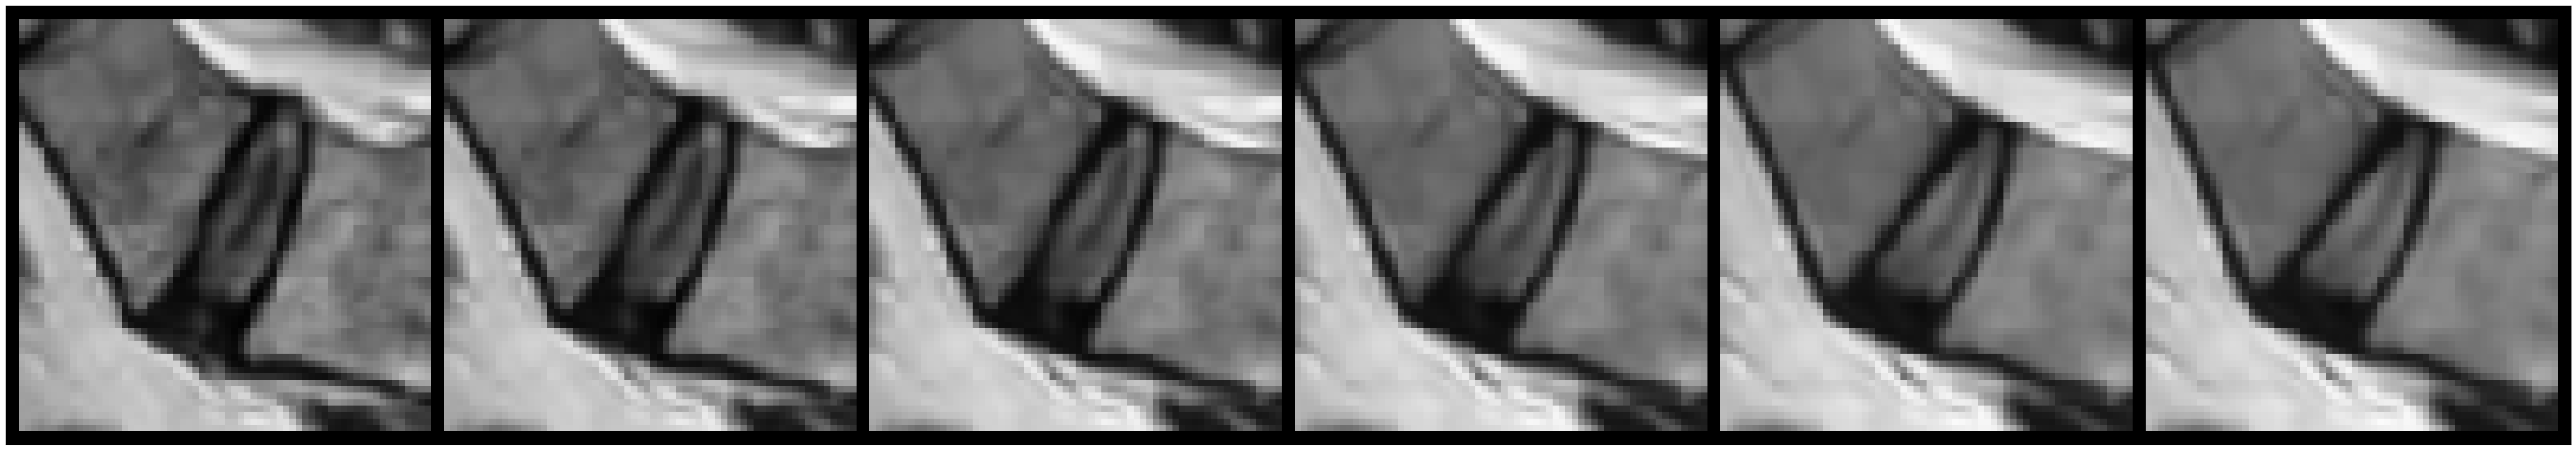

GT Grade:  1
Before (Dist, Reg):  2.258389938965854 2.0
[(2.258389938965854, 2.0), (2.327708451495497, 2.0), (2.4663454762159946, 3.0), (2.604982500936492, 3.0), (2.7436195256569897, 4.0), (2.8822565503774875, 4.0)]


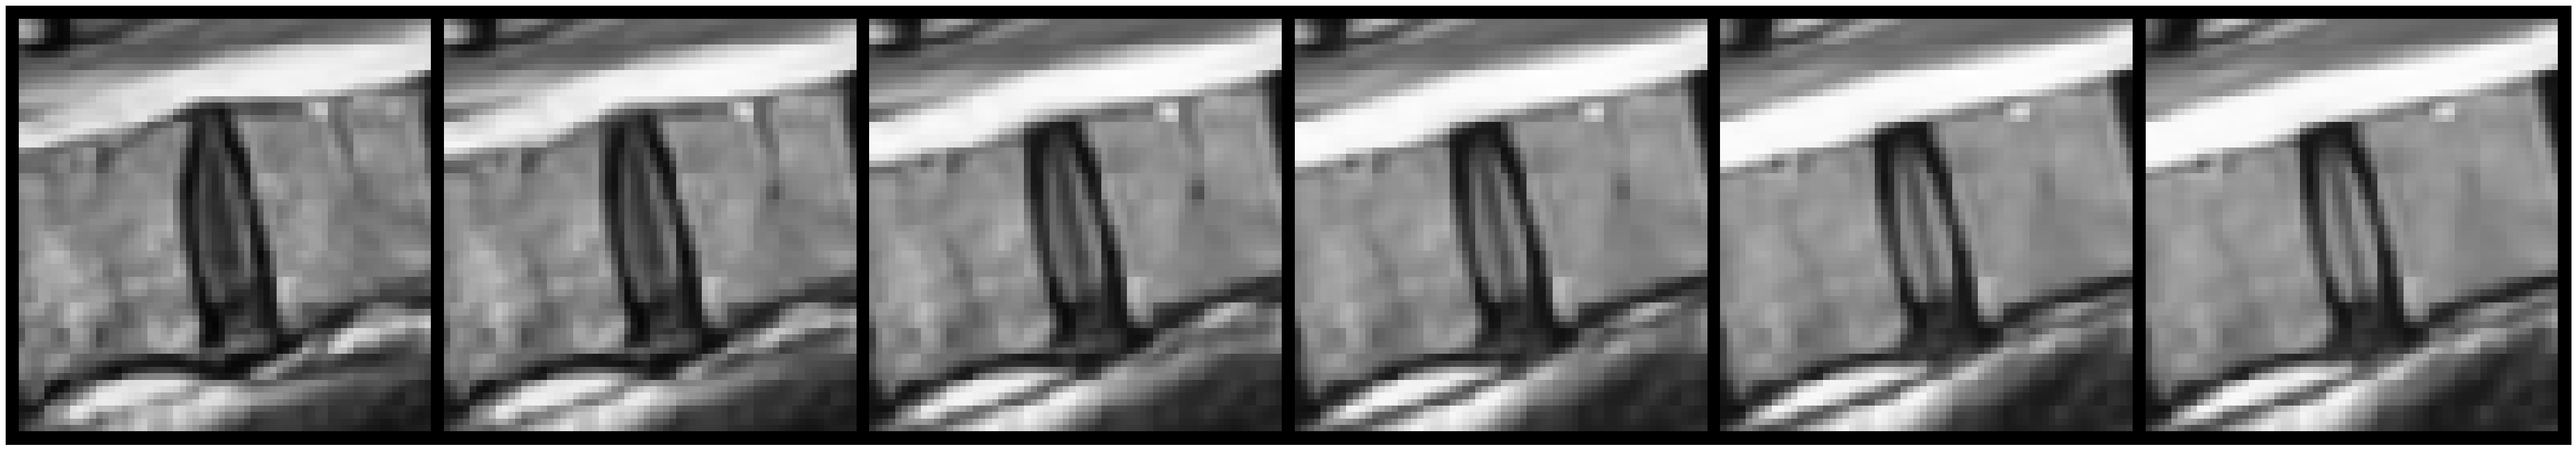

In [22]:
for i, batch in enumerate(val_loader):
    gt_grade = batch["pfirrman_grade"].item()
    if gt_grade not in [0, 1]:
        continue
    print("GT Grade: ", gt_grade)
    orig_img = batch["image"].to(device)
    
    cond =  model.encode(orig_img, ema=True)
    xT = model.encode_stochastic(orig_img, cond, T=250, ema=True)
    recon_img = model.render(xT, cond, T=100, ema=True)

    with torch.no_grad():
        edit_conds = move_across_boundary(cond, svm_model, gt_grade)
    
    edit_imgs = model.render(torch.cat([xT for i in range(len(edit_conds))]), torch.cat(edit_conds, dim=0), T=100, ema=True)
    grid = torchvision.utils.make_grid(torch.cat([edit_imgs, recon_img], dim=0))
    show(grid)
    plt.show(block=False)

    if i == 30:
        break
